In [14]:
import sys
sys.path.insert(0, '/home/cameron/Projects/hypso-package')

import matplotlib.pyplot as plt

## Read NetCDF File

In [2]:
# Import Satellite Object
from hypso import Hypso1
import os

# Define HYPSO Image File and the .points from QGIS (if available)
dir_path = '/home/cameron/Dokumenter/Data/frohavet'
nc_file = os.path.join(dir_path, 'frohavet_2024-05-06_1017Z-l1a.nc')
points_file = os.path.join(dir_path, 'frohavet_2024-05-06_1017Z-bin3.points')

# Create Satellite Object
satobj = Hypso1(hypso_path=nc_file, points_path=points_file, verbose=True)

[INFO] Capture spatial dimensions: (598, 1092)
[INFO] Capture capture type: wide
[INFO] Running georeferencing...
No image mode provided. Detected image mode: bin3
[INFO] Using UTM map: WGS 84 / UTM zone 32N EPSG: 32632


## Generate L1B datacube

In [3]:
satobj.generate_l1b_cube()

[INFO] Running calibration routines...
[INFO] Running radiometric calibration...
[INFO] Running smile correction...
[INFO] Running destriping correction...


## Generate chlorophyll estimates

In [4]:
#satobj.generate_chlorophyll_estimates('band_ratio')

## Load area definition

In [5]:
from pyresample import load_area
area_def = load_area("./frohavet_demo.yaml")

In [6]:
area_def

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Area ID: frohavet
Description: roi
Projection: {'ellps': 'bessel', 'lat_0': '90', 'lat_ts': '63.9537056254799', 'lon_0': '9.45716076150201', 'no_defs': 'None', 'proj': 'stere', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 611
Number of rows: 1173
Area extent: (-97518.172, -2982987.184, 86005.9804, -2630840.3038)

In [7]:
resampled_l1a_cube = satobj.resample_l1a_cube(area_def=area_def)
resampled_l1b_cube = satobj.resample_l1b_cube(area_def=area_def)

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [11]:
resampled_chlorophyll_estimates = satobj.resample_chlorophyll_estimates(area_def=area_def)

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [13]:
resampled_chlorophyll_estimates['band_ratio']

<xarray.DataArray 'reshape-c93396b6db9f91d041444a7848c3df2f' (y: 1173, x: 611)>
dask.array<reshape, shape=(1173, 611), dtype=float64, chunksize=(1173, 611), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -9.737e+04 -9.707e+04 ... 8.556e+04 8.586e+04
  * y        (y) float64 -2.631e+06 -2.631e+06 ... -2.983e+06 -2.983e+06
Attributes:
    model:    None

In [10]:
satobj.generate_chlorophyll_estimates('band_ratio')

[INFO] Running band ratio chlorophyll estimation...
[INFO] Calibration has already been run. Skipping.


In [11]:
satobj.chl.items()

dict_items([('band_ratio', <xarray.DataArray (y: 598, x: 1092)>
array([[1.98022832, 2.05960769, 2.13993502, ..., 2.07018929, 2.11488065,
        2.13693884],
       [1.99693084, 2.04626501, 2.12055055, ..., 2.074117  , 2.1210269 ,
        2.15617209],
       [1.96243844, 2.06636836, 2.14997843, ..., 2.06486062, 2.10787848,
        2.17818626],
       ...,
       [1.60307765, 1.67246476, 1.69454884, ..., 0.44005545, 0.45899856,
        0.45411241],
       [1.58991106, 1.67528404, 1.70408382, ..., 0.56192994, 0.57576979,
        0.56972605],
       [1.57137012, 1.67516158, 1.68133342, ..., 0.37659181, 0.39257584,
        0.40941384]])
Dimensions without coordinates: y, x
Attributes:
    description:  Chlorophyll estimates
    method:       549 nm over 663 nm band ratio
    factor:       0.1
    units:        a.u.
    model:        None)])

## Get L1A SatPy scene

In [6]:
l1a_scene = satobj.get_l1a_satpy_scene()

## Get chlorophyll estimates SatPy scene

In [7]:
chl_scene = satobj.get_chlorophyll_estimates_satpy_scene()

## Resample capture to area defintion

In [8]:
import numpy as np

resampled_l1a_scene = l1a_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)
resampled_chl_scene = chl_scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


## Convert to NumPy

In [9]:
ds = resampled_l1a_scene.to_xarray()
#ds = resampled_l1a_scene.to_xarray(datasets=['band_1', 'band_10', 'band_2'])
ds = ds.drop_vars('frohavet')
ordered_ds = ds[sorted(ds.data_vars, key=lambda x: int(x.split('_')[1]))]
numpy_array = ordered_ds.to_array().to_numpy()
numpy_array = np.transpose(numpy_array, (1, 2, 0))


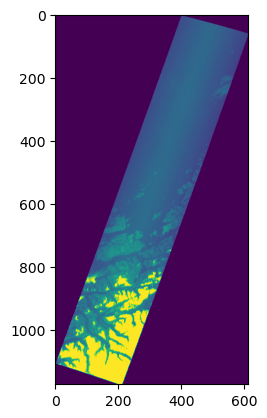

In [10]:
import matplotlib.pyplot as plt
plt.imshow(numpy_array[:,:,40])

In [12]:
from pyresample.bilinear.xarr import XArrayBilinearResampler 
from pyresample.geometry import SwathDefinition
import numpy as np
import matplotlib.pyplot as plt

In [13]:
swath_def = SwathDefinition(lons=satobj.longitudes, lats=satobj.latitudes)

In [14]:
brs = XArrayBilinearResampler(source_geo_def=swath_def, target_geo_def=area_def, radius_of_influence=50000)

In [11]:
brs.get_bil_info()

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [7]:
print(area_def.shape)
print(satobj.l1a_cube.shape)

(1173, 611)
(598, 1092, 120)


In [12]:
brs.resample(satobj.l1a_cube[:,:,3], fill_value=np.nan)

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


<xarray.DataArray 'reshape-3b96b044691f8a80a76f7474ff45ab9c' (y: 1173, x: 611)>
dask.array<reshape, shape=(1173, 611), dtype=float64, chunksize=(1173, 611), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -9.737e+04 -9.707e+04 ... 8.556e+04 8.586e+04
  * y        (y) float64 -2.631e+06 -2.631e+06 ... -2.983e+06 -2.983e+06

In [57]:
satobj.l1a_cube.coords

Coordinates:
    *empty*

In [13]:
data_list = [satobj.l1a_cube[:,:,40], satobj.l1a_cube[:,:,41], satobj.l1a_cube[:,:,42]]
[brs.resample(ds, fill_value=np.nan) for ds in data_list]

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._c

[<xarray.DataArray 'reshape-2097d7e707750708ede4987e16d0b52a' (y: 1173, x: 611)>
 dask.array<reshape, shape=(1173, 611), dtype=float64, chunksize=(1173, 611), chunktype=numpy.ndarray>
 Coordinates:
   * x        (x) float64 -9.737e+04 -9.707e+04 ... 8.556e+04 8.586e+04
   * y        (y) float64 -2.631e+06 -2.631e+06 ... -2.983e+06 -2.983e+06,
 <xarray.DataArray 'reshape-347cc53b7b1cd4aea97669fc6cdc41eb' (y: 1173, x: 611)>
 dask.array<reshape, shape=(1173, 611), dtype=float64, chunksize=(1173, 611), chunktype=numpy.ndarray>
 Coordinates:
   * x        (x) float64 -9.737e+04 -9.707e+04 ... 8.556e+04 8.586e+04
   * y        (y) float64 -2.631e+06 -2.631e+06 ... -2.983e+06 -2.983e+06,
 <xarray.DataArray 'reshape-0b66f9fb5d221b506f4b2f6475b4a5dd' (y: 1173, x: 611)>
 dask.array<reshape, shape=(1173, 611), dtype=float64, chunksize=(1173, 611), chunktype=numpy.ndarray>
 Coordinates:
   * x        (x) float64 -9.737e+04 -9.707e+04 ... 8.556e+04 8.586e+04
   * y        (y) float64 -2.631e+06 -2.

In [18]:
x = brs.get_sample_from_bil_info(data=satobj.l1a_cube[:,:,60], fill_value=np.nan, output_shape=area_def.shape)

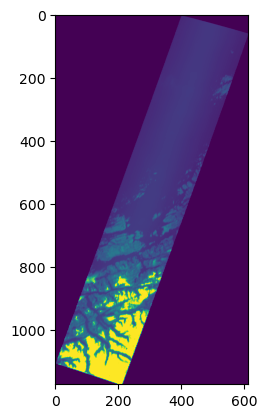

In [21]:

plt.imshow(x)

In [13]:
area_def.shape

(1173, 611)

In [5]:
satobj._resample_l1a_cube(geo_def=area_def)

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


<xarray.DataArray (y: 1173, x: 611, band: 120)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Dimensions without coordinates: y, x, band
Attributes:
    level:        L1a
    units:        a.u.
    description:  Raw sensor value

In [17]:
import xarray as xr
from pyresample.bilinear.xarr import XArrayBilinearResampler 
from pyresample.geometry import SwathDefinition
import numpy as np
import matplotlib.pyplot as plt

data=satobj.l1a_cube
geo_def = area_def
swath_def = satobj._generate_swath_definition()

brs = XArrayBilinearResampler(source_geo_def=swath_def, target_geo_def=geo_def, radius_of_influence=50000)

# Calculate bilinear neighbour info
brs.get_bil_info()

if data.ndim == 2:
    resampled_data = brs.resample(data=data[:,:], fill_value=np.nan)

elif data.ndim == 3:

    num_bands = data.shape[2]

    resampled_data = np.zeros((geo_def.shape[0], geo_def.shape[1], num_bands))
    resampled_data = xr.DataArray(resampled_data, dims=satobj.dim_names_3d)
    resampled_data.attrs.update(data.attrs)

    for band in range(0,num_bands):
        
        # Resample using pre-computed resampling LUTs created when XArrayBilinearResampler object was created
        resampled_data[:,:,band] = brs.get_sample_from_bil_info(data=data[:,:,band], 
                                                                fill_value=np.nan, 
                                                                output_shape=geo_def.shape)

/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
